In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.linear_model import LinearRegression

# Time efficiency of NCMC protocols

In [2]:
def readdata(filename):
    filelines = open(filename).readlines()
    Nwats = []
    Nsalt = []
    Accprob = []
    time = []
    i=3
    step = int(filelines[i][0:5].strip())
    #while i-3 == step:
    #while i > 0:
    for i in range(3,len(filelines)-3):
        # It appears some of the files have a varying length. This exception will pick those up.
        try:
            dummy = int(filelines[i][6:10].strip())
        except ValueError:
            break
        Nwats.append(int(filelines[i][6:10].strip()))
        Nsalt.append(int(filelines[i][15:18].strip()))
        Accprob.append(float(filelines[i][19:24].strip()))
        time.append(int(filelines[i][24:30].strip()))
        #i += 1
    return np.vstack((np.array(Nwats),np.array(Nsalt),np.array(Accprob),np.array(time)))

Reading in data:

In [3]:
# Results from the initial set of parameters:
nperturbations = [126,512,1024,2048,4096]
npropogations = [1,2,4,8,16,32,64]

nperturbations2 = [512,1024]
npropogations2 = [126,256,512,1024]
pairs = list((x,y) for x in nperturbations for y in npropogations) + list((x,y) for x in nperturbations2 for y in npropogations2)

mean_time = []
for pair in pairs:
    # Reading in data
    filename = 'NCMC_sweep_GHMC/nk{0}_nV{1}/run1.txt'.format(pair[0],pair[1])
    data = readdata(filename) # nwats, nsalt, prob, time
    mean_time.append(data[3].mean()/10)
        
mean_time = np.array(mean_time)
pairs = np.array(pairs)

# Model for timings
There is a small overhead for each perturbation due to changing the parameters in contex. If $t_p$ is the time for the overhead for a single _perturbation_, $t_s$ the time for a single MD _step_, $n$ is the number of perturbations, and $m$ the number of propagation steps per perturbation, the total time is given by

$$ \text{Total simulation time} = t_pn + t_snm $$

In [4]:
# Formating the data I will use to fit the model
pairs = np.array(pairs)
x1 = np.prod(pairs,axis=1)  # The product of perturbations and propagation steps per perturbation
x1 = x1.reshape(len(x1),1)

x2 = pairs[:,0]
x2 = x2.reshape(len(x2),1)
x2 = np.hstack((x2,x1))

y = mean_time.reshape(len(mean_time),1)

Overhead per perturbation = 0.001379s
Time taken for a single propagation step = 0.001904s
Intercept = -1.476793


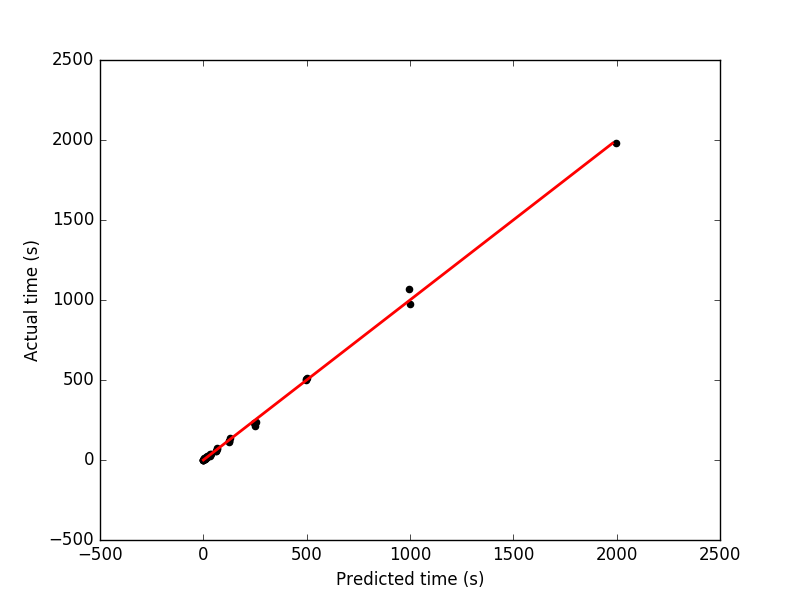

In [5]:
regr = LinearRegression()
regr.fit(x2,y)

# The coefficient
print 'Overhead per perturbation = {0}s'.format(round(regr.coef_[0][0],6))
print 'Time taken for a single propagation step = {0}s'.format(round(regr.coef_[0][1],6))
print 'Intercept = {0}'.format(round(regr.intercept_,6))

# Plot outputs
perfect = np.linspace(0,y.max())
plt.clf()
plt.scatter(regr.predict(x2),y, color='black')
plt.plot(perfect,perfect, color='red',linewidth=2)
plt.xlabel('Predicted time (s)')
plt.ylabel('Actual time (s)')
plt.savefig('temp.png',format='png')
Image("temp.png")

This suggests the overhead is almost as large as the time for each individual MD timestep during propagation, althought the contribution is much less because $nm$ is very large in the simulations I've run.

It doesn't seem right that the intercept is negative.

# Simpler model
There is a no overhead for each perturbation due to changing the parameters in context. We know this is not the case. If $t_s$ the time for a single MD _step_, $n$ is the number of perturbations, and $m$ the number of propagation steps per perturbation, the total time is given by

$$ \text{Total time} = t_snm $$

Time taken for a single perturbation and single propagation step = 0.001903s
Intercept = 0.490039


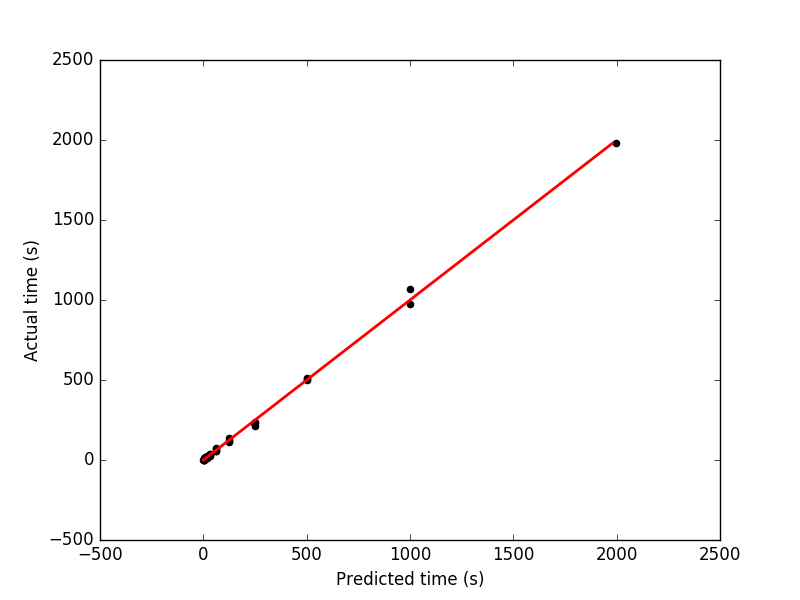

In [6]:
regr = LinearRegression()
regr.fit(x1,y)

# The coefficient
print 'Time taken for a single perturbation and single propagation step = {0}s'.format(round(regr.coef_[0][0],6))
print 'Intercept = {0}'.format(round(regr.intercept_,6))

# Plot outputs
plt.clf()
perfect = np.linspace(0,y.max())
plt.scatter(regr.predict(x1), y,  color='black')
plt.plot(perfect,perfect, color='red',linewidth=2)
plt.xlabel('Predicted time (s)')
plt.ylabel('Actual time (s)')
plt.savefig('temp.png',format='png')
Image("temp.png")

Predicted a very similar time for the MD propagation step. 

I can't get my head around the intercept here either.